# AtmoML Hyperparameter Tuning

In [1]:
import logging
import keras_tuner
import keras
import tensorflow as tf
import time
import pathlib
import os



from usl_models.atmo_ml.model import AtmoModel
from usl_models.atmo_ml import dataset, visualizer, vars

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)
visualizer.init_plt()

batch_size = 8
filecache_dir = pathlib.Path("/home/shared/climateiq/filecache")
example_keys = [
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-25"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-26"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-27"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-28"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-25"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-26"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-27"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-28"),
]
timestamp = time.strftime("%Y%m%d-%H%M%S")

ds_config = dataset.Config(output_timesteps=2)
train_ds = dataset.load_dataset_cached(
    filecache_dir,
    example_keys=example_keys,
    config=ds_config,
).batch(batch_size=batch_size)
val_ds = dataset.load_dataset_cached(
    filecache_dir,
    example_keys=example_keys,
    config=ds_config,
    shuffle=False,
).batch(batch_size=batch_size)
# Create a MirroredStrategy to parallelize training on multiple GPUs
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

2025-04-29 15:46:10.217061: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 15:46:10.266846: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-29 15:46:10.266879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-29 15:46:10.268060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 15:46:10.275930: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [2]:
# with strategy.scope():
tuner = keras_tuner.BayesianOptimization(
    AtmoModel.get_hypermodel(
        input_cnn_kernel_size=[1, 2, 5],
        lstm_kernel_size=[5],
        spatial_activation=["relu"],
        st_activation=["relu"],
        lstm_activation=["relu"],
        output_activation=["tanh"],
    ),
    objective="val_loss",
    max_trials=10,
    project_name=f"logs/htune_project_{timestamp}",
)
tuner.search_space_summary()


Search space summary
Default search space size: 6
input_cnn_kernel_size (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 5], 'ordered': True}
lstm_kernel_size (Choice)
{'default': 5, 'conditions': [], 'values': [5], 'ordered': True}
spatial_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu'], 'ordered': False}
st_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu'], 'ordered': False}
lstm_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu'], 'ordered': False}
output_activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh'], 'ordered': False}


In [3]:
log_dir = f"logs/htune_{timestamp}"
print(log_dir)
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
tuner.search(train_ds, epochs=100, validation_data=val_ds, callbacks=[tb_callback])
best_model, best_hp = tuner.get_best_models()[0], tuner.get_best_hyperparameters()[0]
best_hp.values

Trial 3 Complete [00h 05m 16s]
val_loss: 0.0016243580030277371

Best val_loss So Far: 0.0016243580030277371
Total elapsed time: 00h 11m 33s


{'input_cnn_kernel_size': 1,
 'lstm_kernel_size': 5,
 'spatial_activation': 'relu',
 'st_activation': 'relu',
 'lstm_activation': 'relu',
 'output_activation': 'tanh'}

In [4]:
# with strategy.scope():
# Re-create the model using the best hyperparameters
final_params = AtmoModel.Params(**best_hp.values)
model = AtmoModel(params=final_params)
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
model.fit(train_ds, val_ds, epochs=100, callbacks=[tb_callback], validation_freq=1)
model.save_model(log_dir + "/model")


Epoch 1/100


2025-04-29 15:57:56.752996: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inatmo_conv_lstm_1/conv_lstm/conv_lstm2d_1/while/body/_1/atmo_conv_lstm_1/conv_lstm/conv_lstm2d_1/while/dropout_7/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 13s 13s/step - loss: 0.1332 - mean_absolute_error: 0.2918 - root_mean_squared_error: 0.3649 - mean_squared_logarithmic_error: 0.0877 - nrmse: 0.4014 - ssim_metric: 0.0607 - psnr_metric: 4.4171 - mse_RH2: 0.1826 - mse_T2: 0.2155 - mse_WSPD_WDIR10: 0.0014 - val_loss: 0.1267 - val_mean_absolute_error: 0.2820 - val_root_mean_squared_error: 0.3560 - val_mean_squared_logarithmic_error: 0.0796 - val_nrmse: 0.3916 - val_ssim_metric: 0.1407 - val_psnr_metric: 4.5307 - val_mse_RH2: 0.1548 - val_mse_T2: 0.1810 - val_mse_WSPD_WDIR10: 0.0444
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 0.1254 - mean_absolute_error: 0.2798 - root_mean_squared_error: 0.3541 - mean_squared_logarithmic_error: 0.0790 - nrmse: 0.3895 - ssim_metric: 0.2608 - psnr_metric: 9.1007 - mse_RH2: 0.1539 - mse_T2: 0.1821 - mse_WSPD_WDIR10: 0.0401 - val_loss: 0.1136 - val_mean_absolute_error: 0.2590 - val_root_mean_squared_error: 0.3370 - val_mean_squared_logarithmic_e

INFO:tensorflow:Assets written to: logs/htune_20250429-154613/model/assets


/home/elhajjas/climateiq-cnn-1/usl_models/usl_models/atmo_ml/visualizer.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, T, figsize=(2 * (T + 0.2), 2), sharey=True)


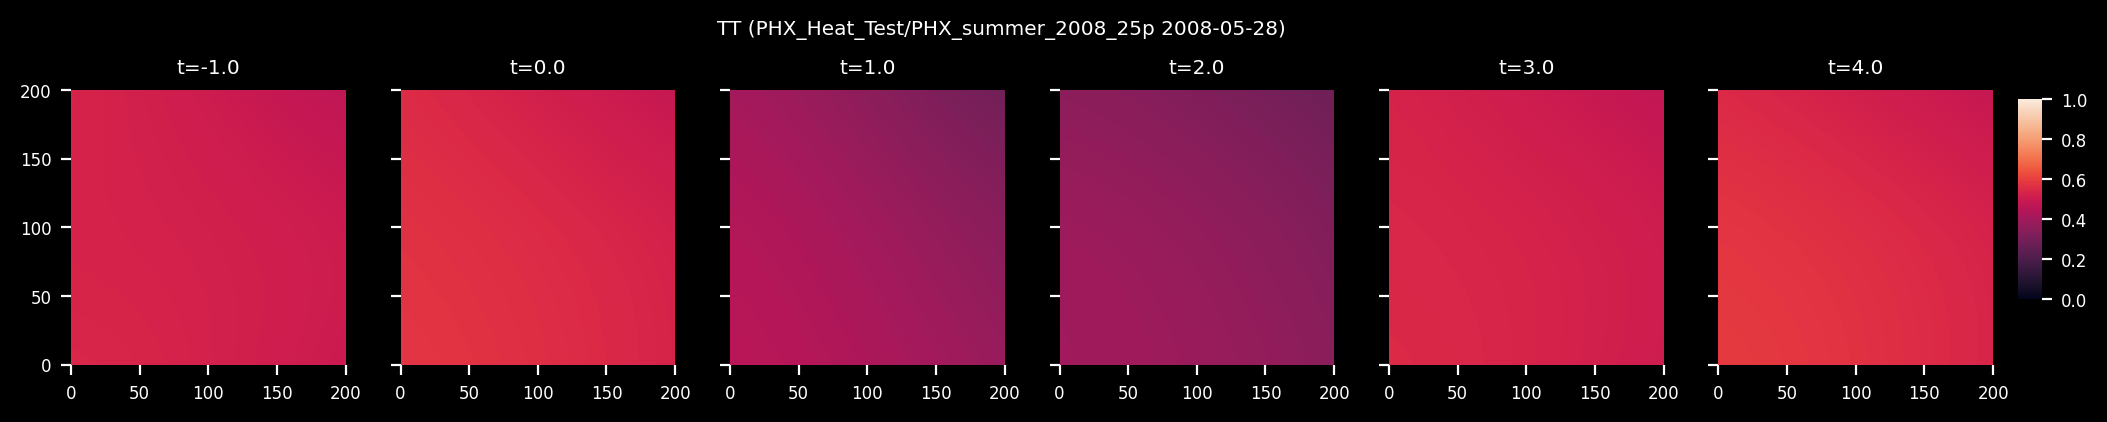

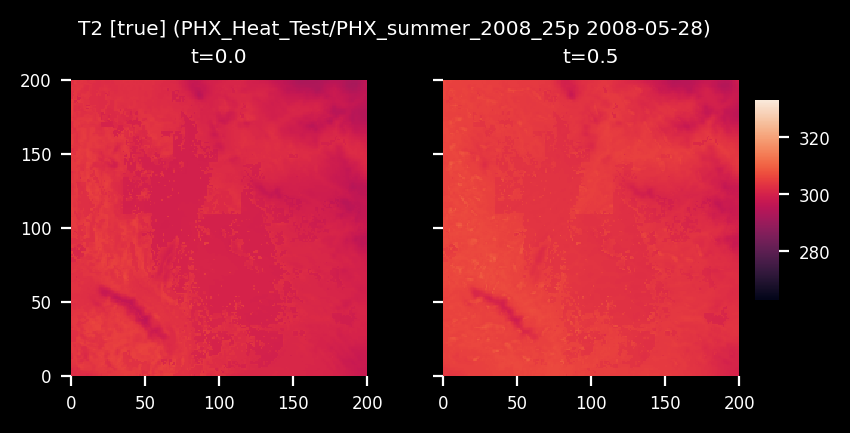

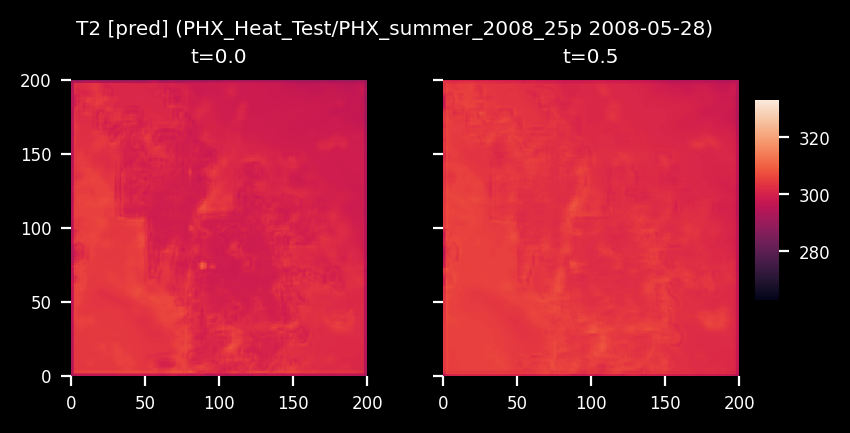

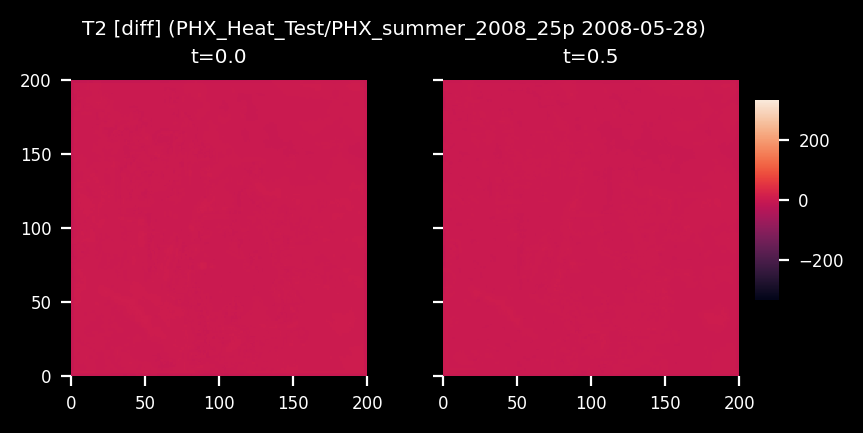

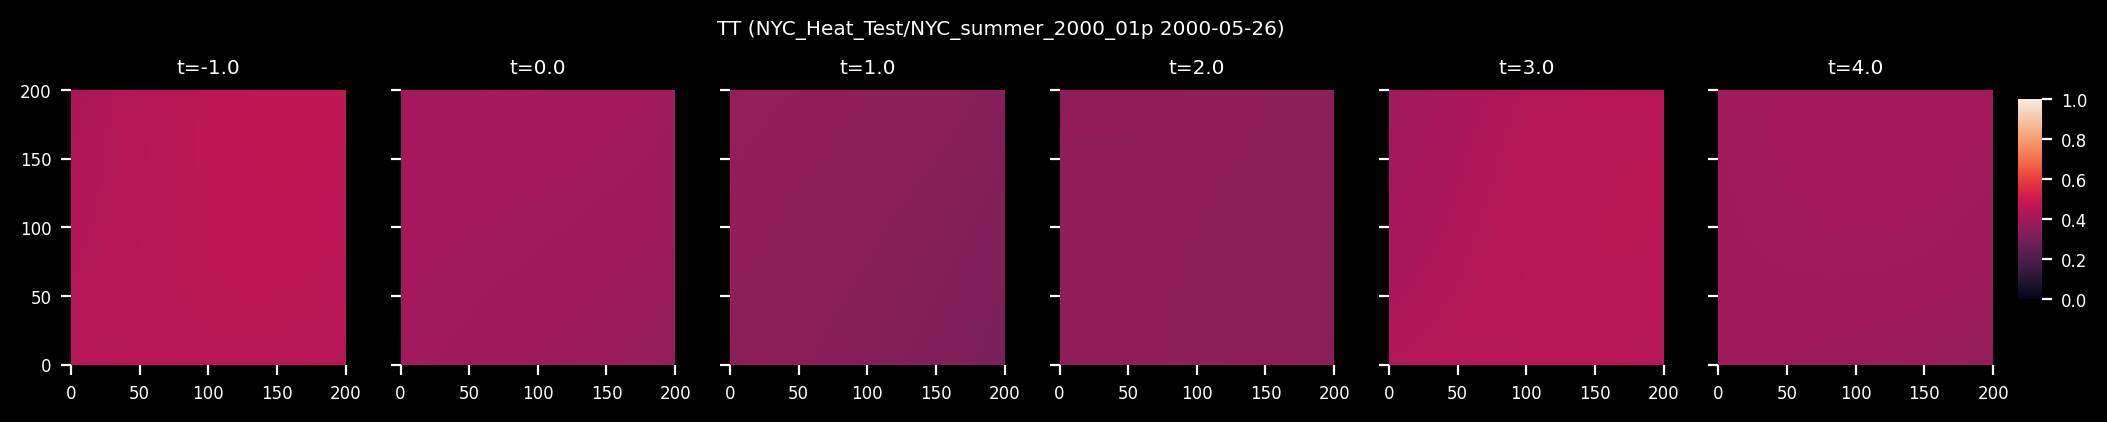

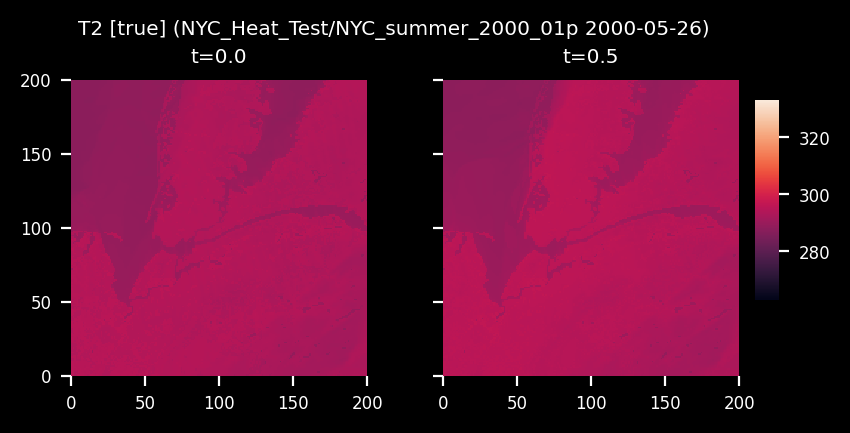

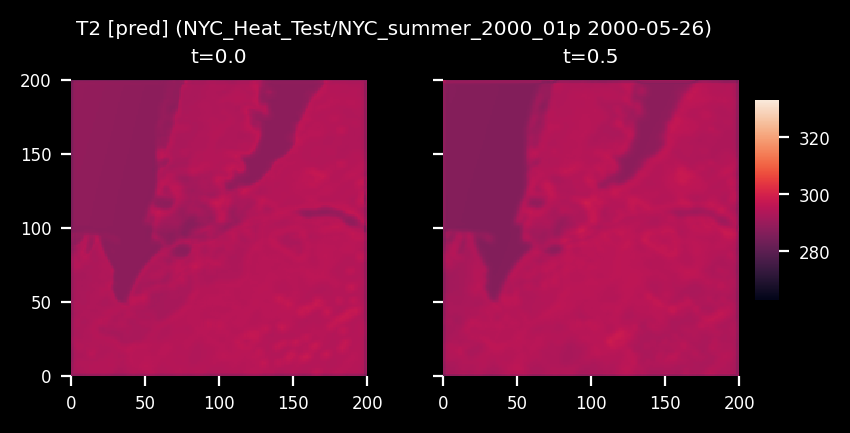

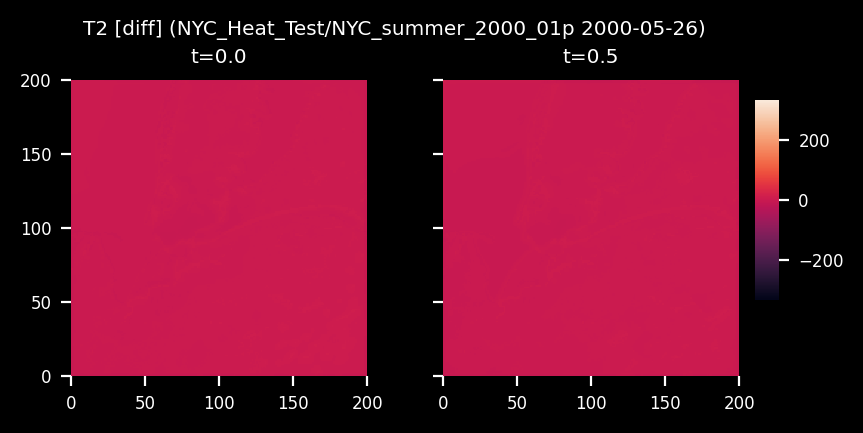

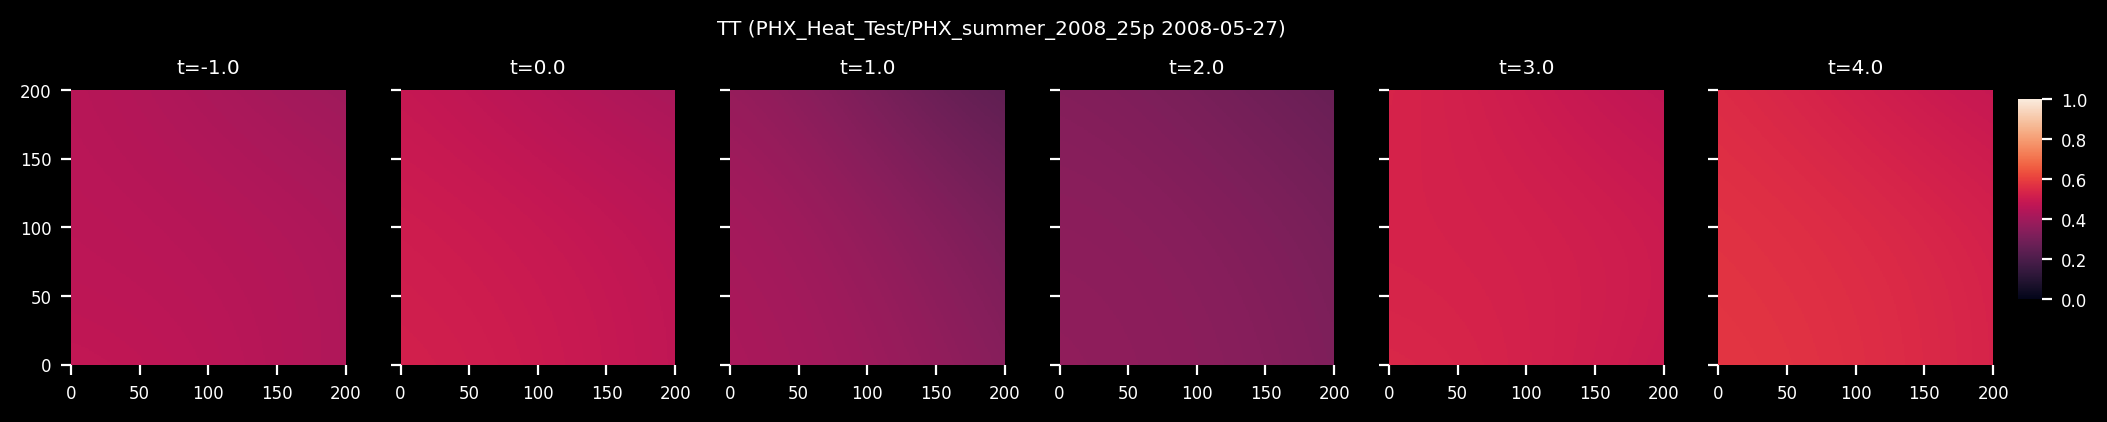

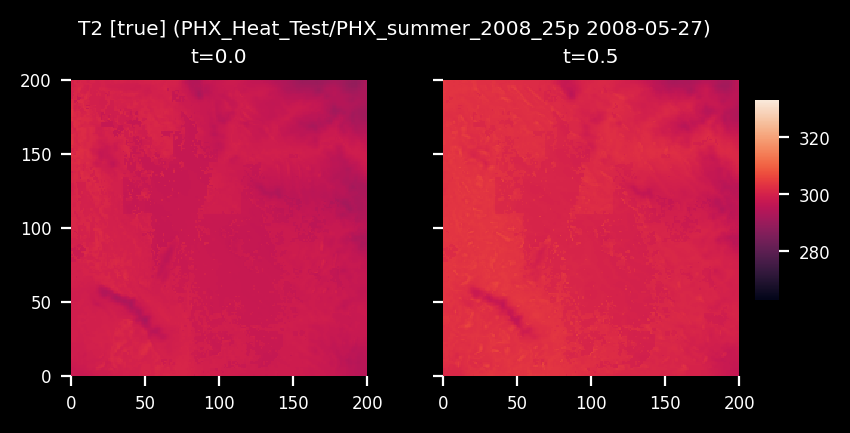

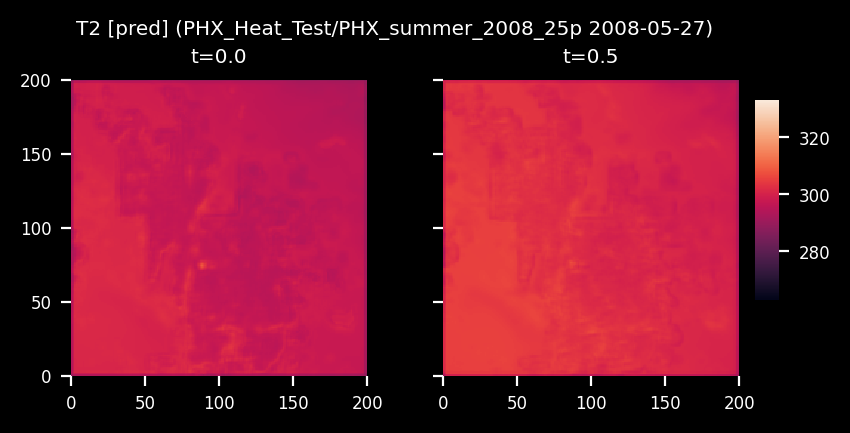

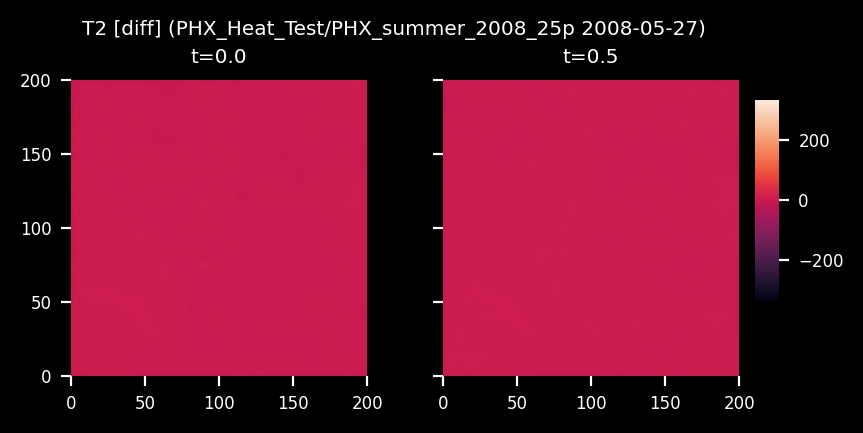

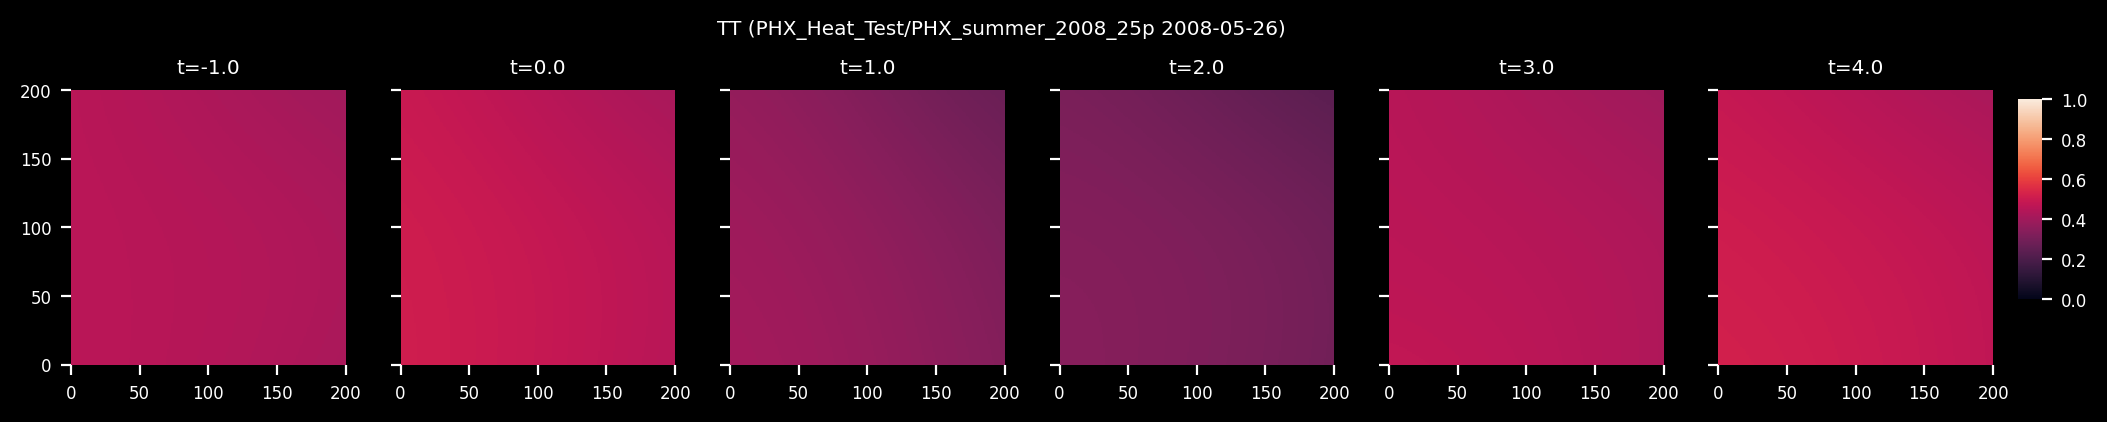

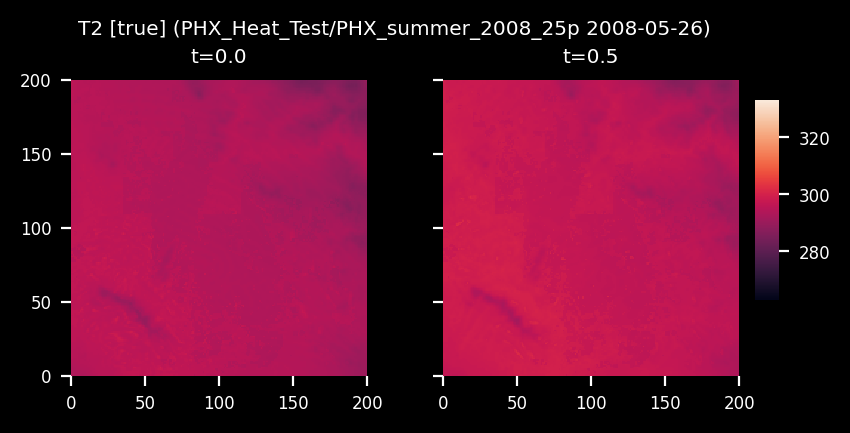

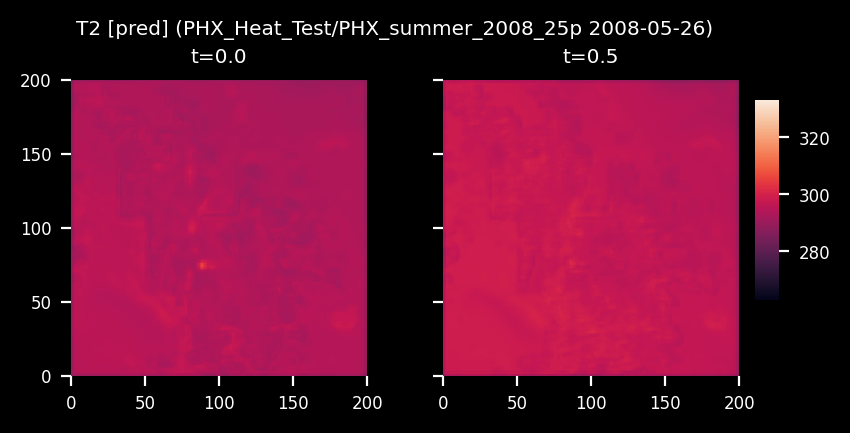

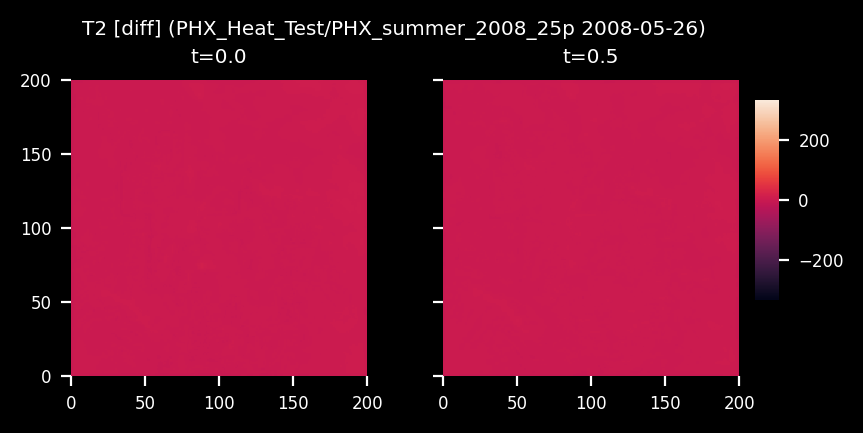

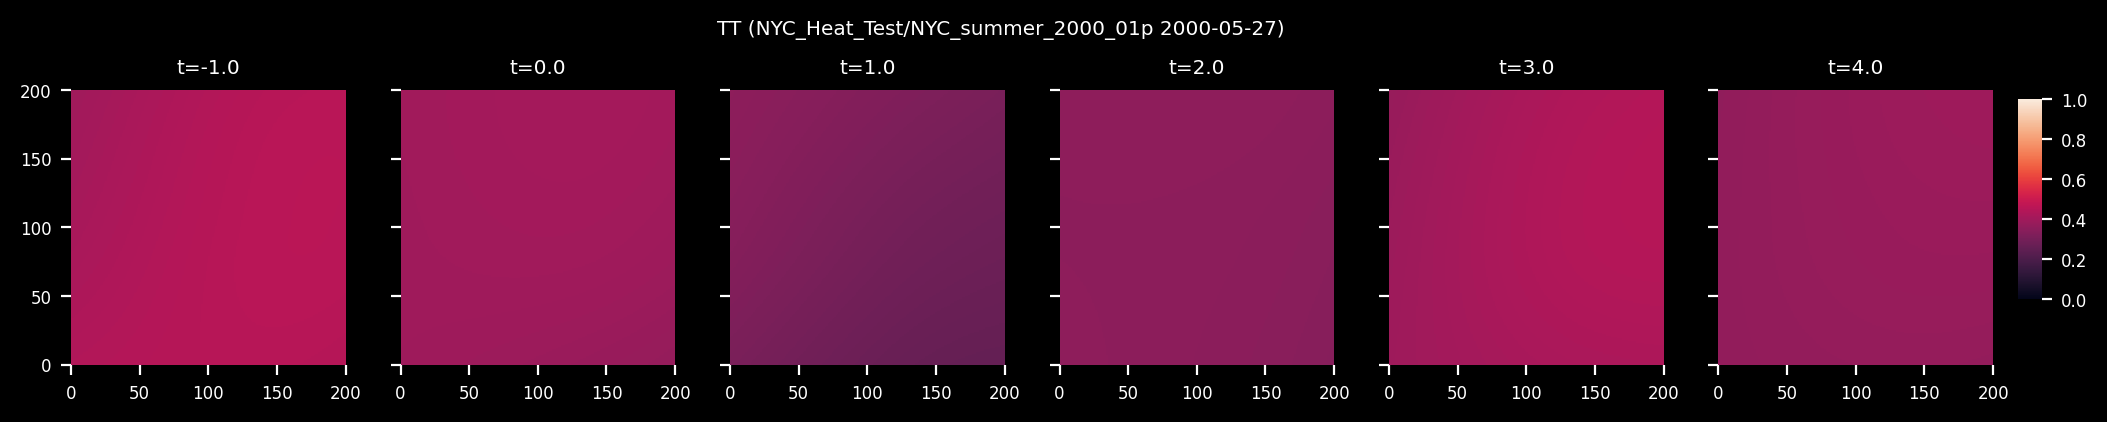

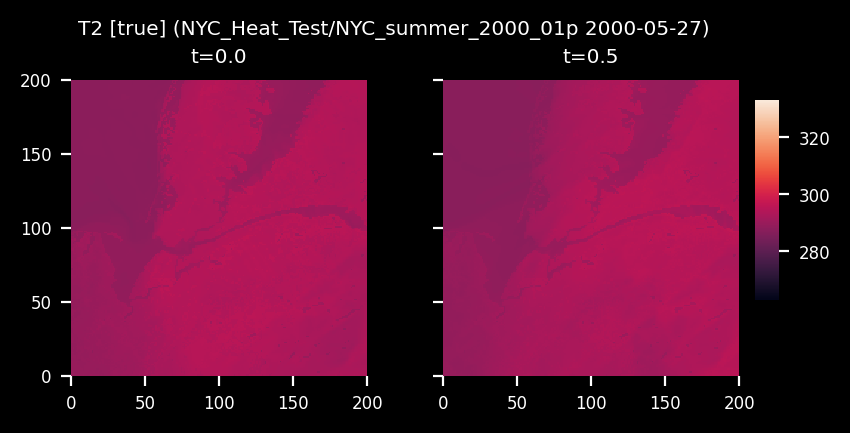

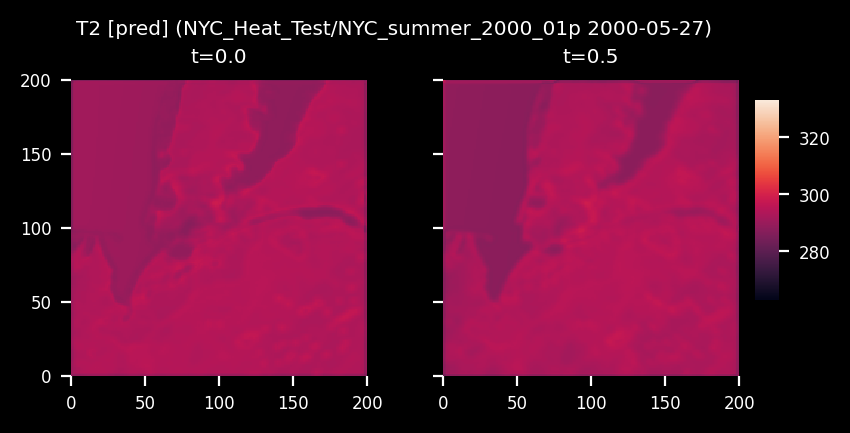

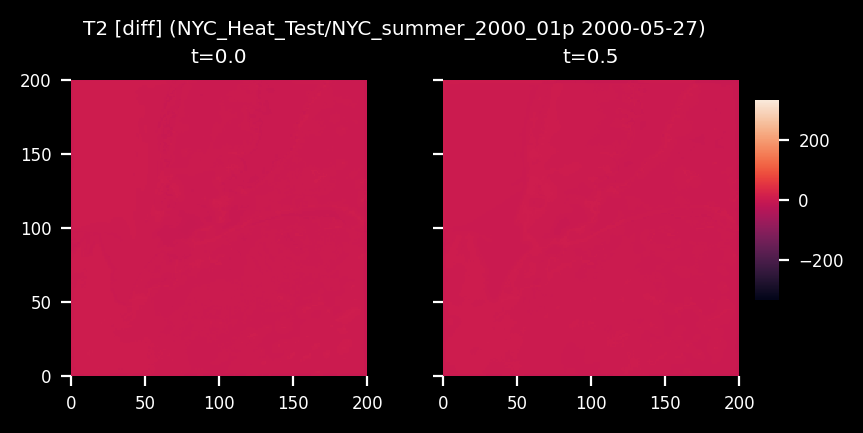

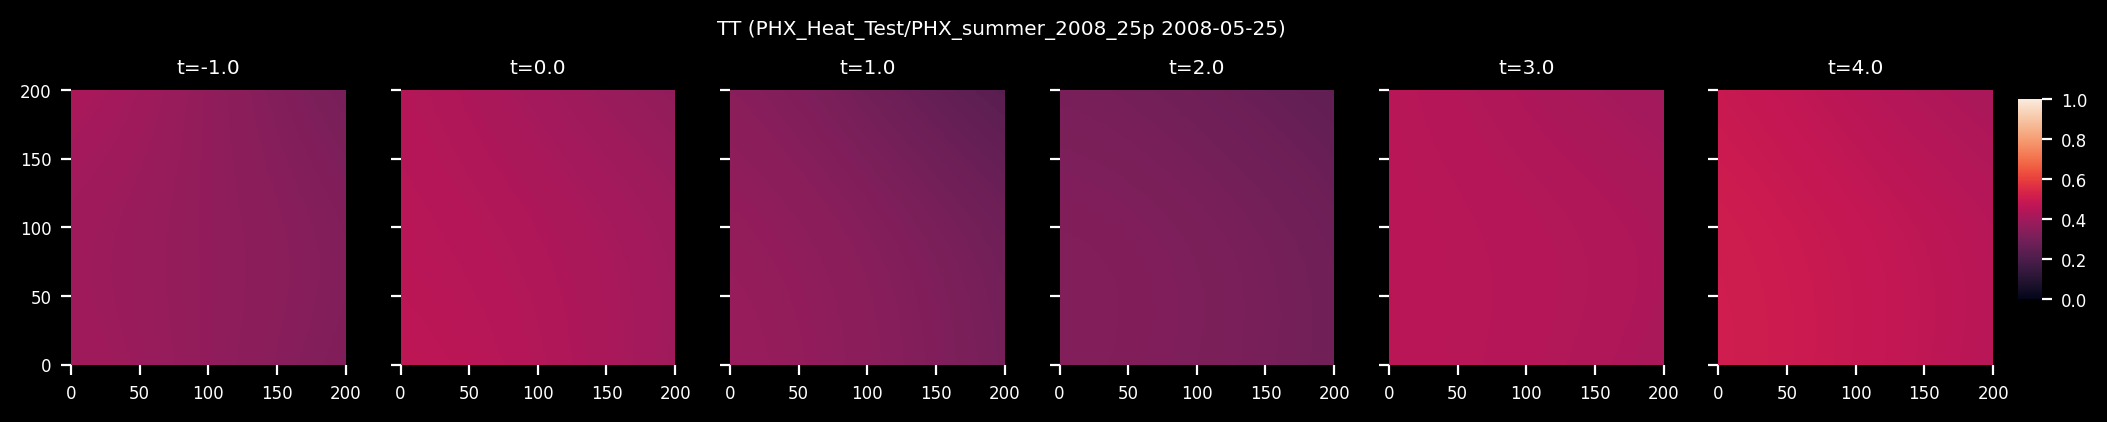

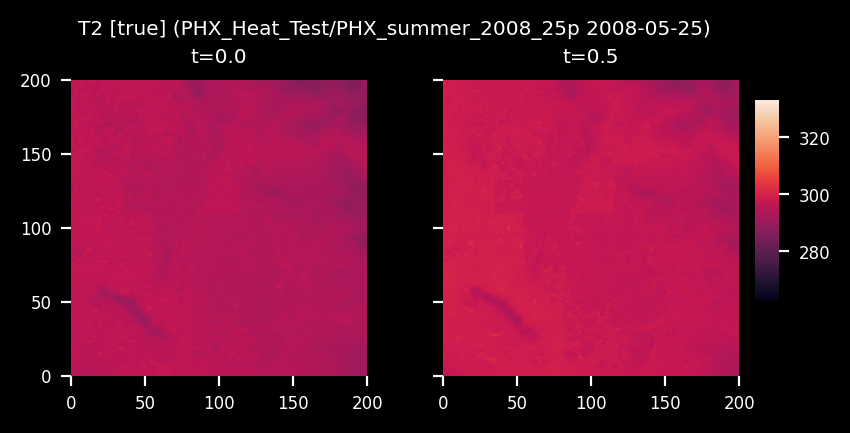

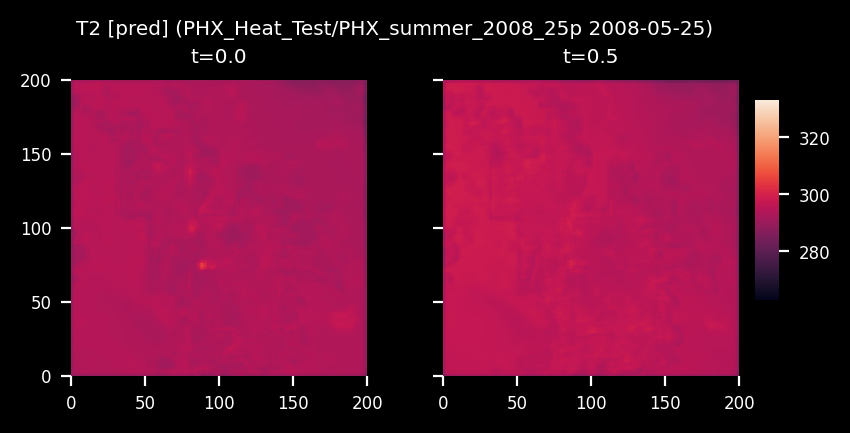

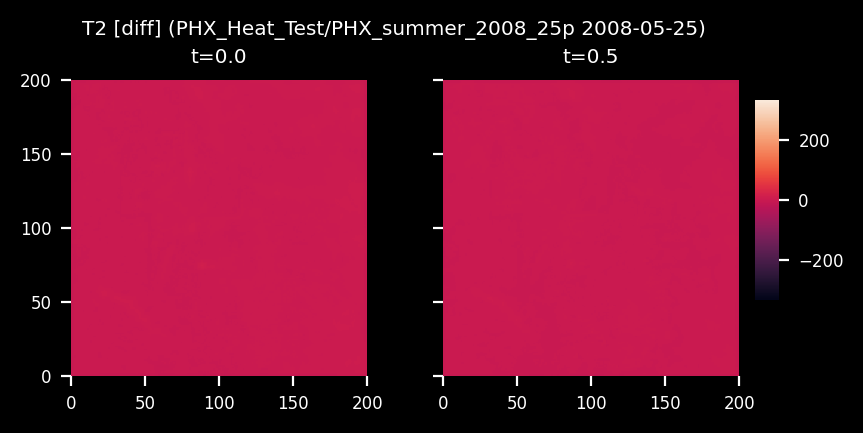

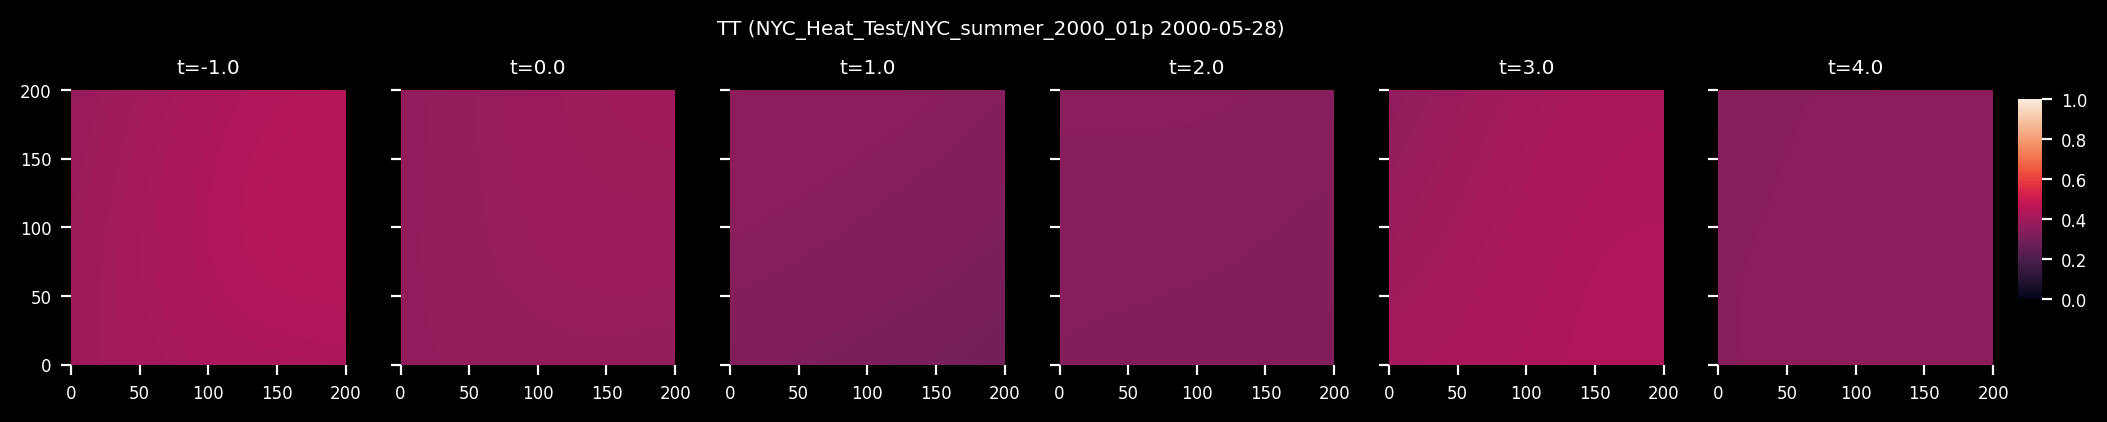

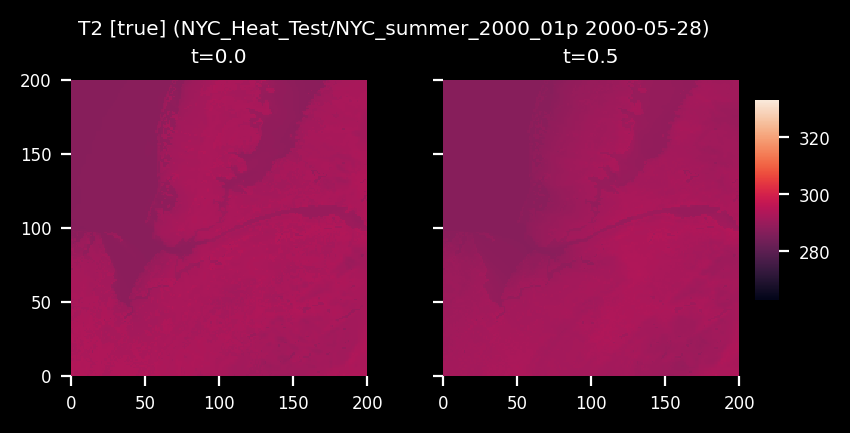

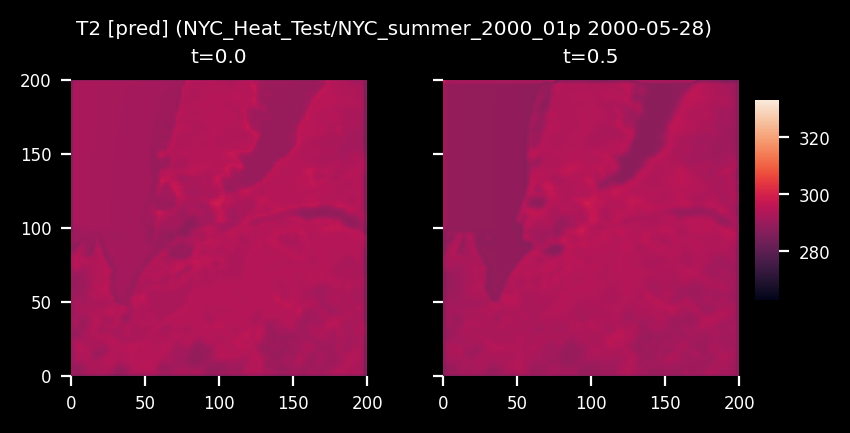

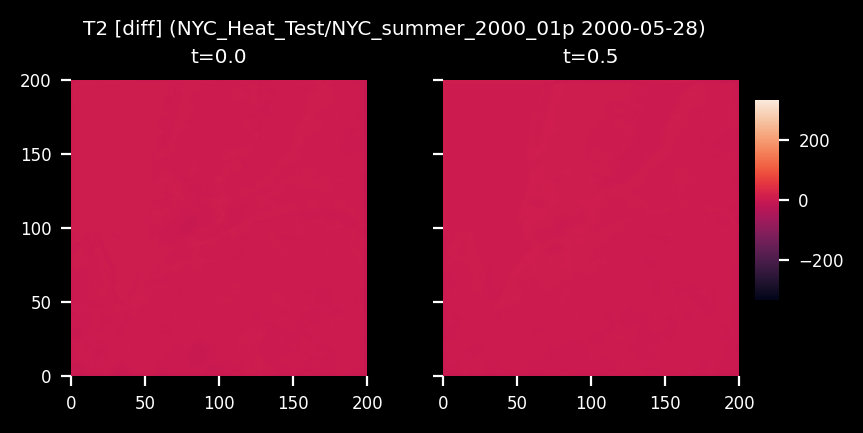

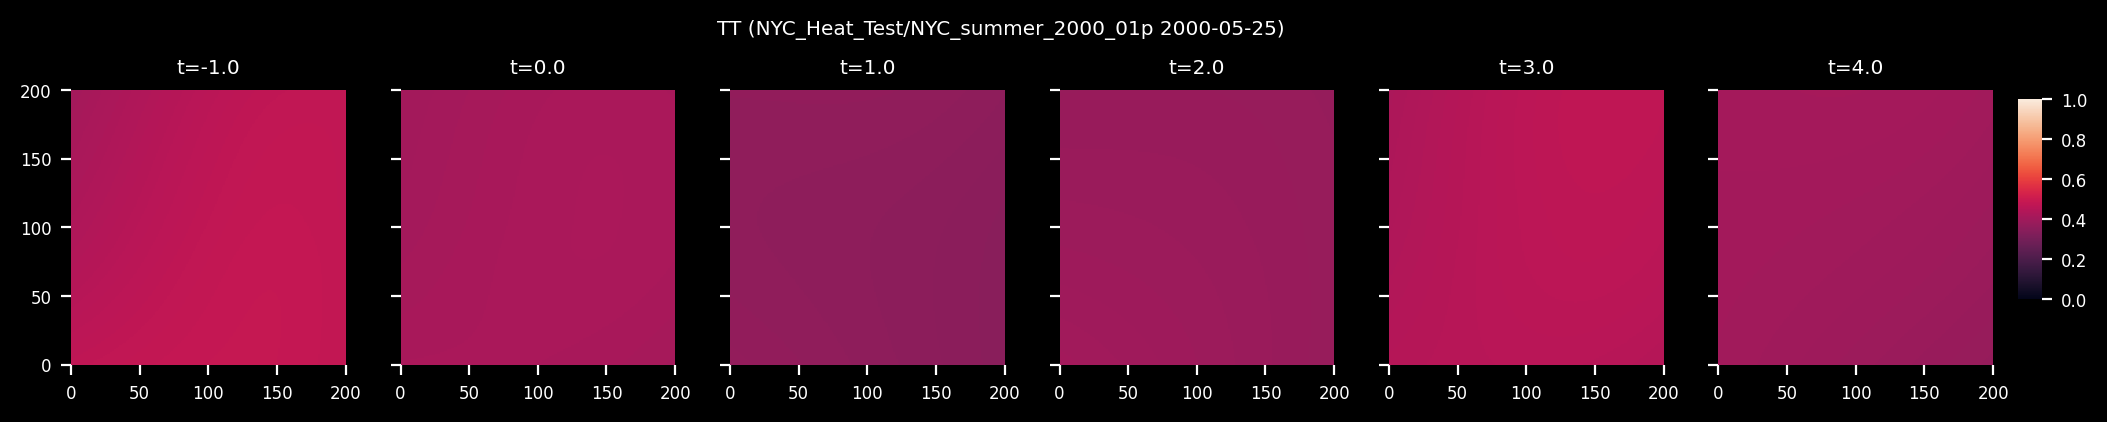

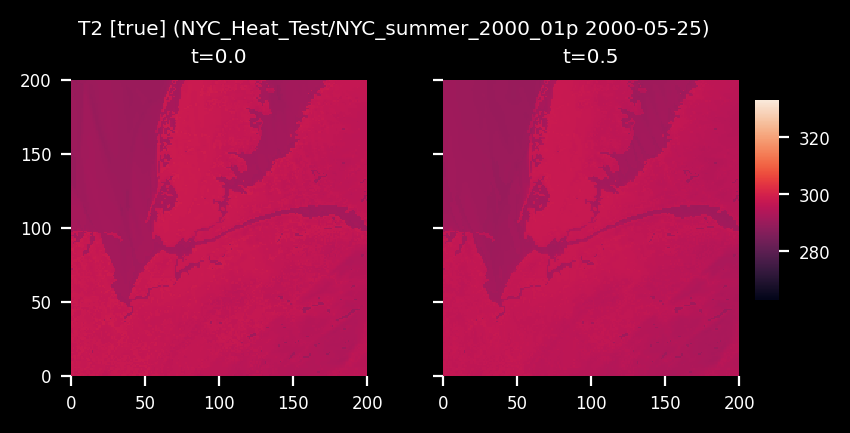

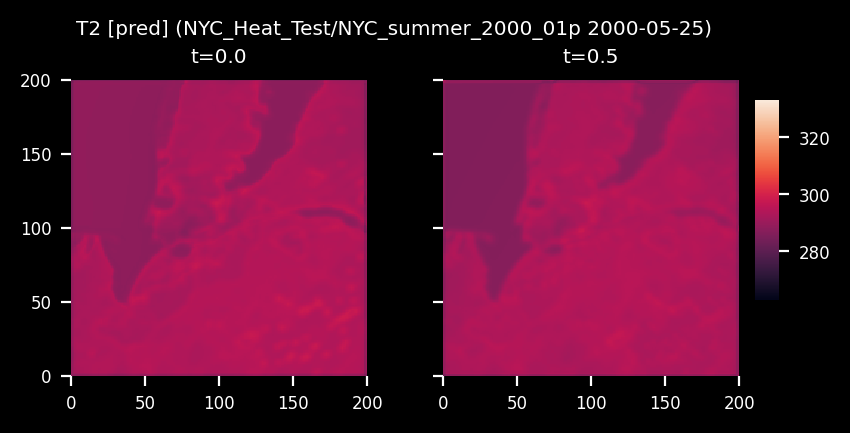

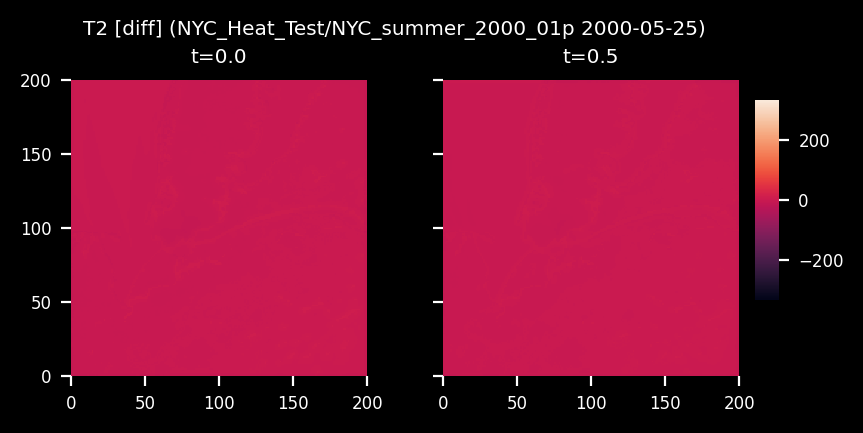

In [5]:
# Plot results
model = AtmoModel.from_checkpoint(log_dir + "/model")
input_batch, label_batch = next(iter(val_ds))
pred_batch = model.call(input_batch)

for fig in visualizer.plot_batch(
    ds_config,
    input_batch=input_batch,
    label_batch=label_batch,
    pred_batch=pred_batch,
    st_var=vars.Spatiotemporal.TT,
    sto_var=vars.SpatiotemporalOutput.T2,
    max_examples=None,
    dynamic_colorscale=False,  # Set to True to compute from data
    unscale= True    # Revert normalization to show true values
):
    fig.show()